# Tutorial de Embeddings en Español: Codificación, Reducción de Dimensionalidad y Clustering

Este tutorial te guiará a través del proceso completo de:
1. **Codificación de embeddings** usando modelos de transformers en español
2. **Reducción de dimensionalidad** con UMAP
3. **Clustering** de las representaciones vectoriales
4. **Visualización** de los resultados

Utilizaremos oraciones sobre diferentes constructos sociales para demostrar cómo los embeddings capturan el significado semántico.


In [ ]:
# Instalación de dependencias
# Ejecuta esta celda si no tienes las librerías instaladas
!pip install sentence-transformers umap-learn plotly
!pip install nbformat


  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 48.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 53.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 47.1 MB/s  0:00:00 eta 0:00:01
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [sentence-transformers]ence-transformers]


In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Datos: Oraciones sobre Constructos Sociales

Vamos a crear un conjunto de oraciones en español que aborden diferentes constructos sociales. Esto nos permitirá ver cómo los embeddings capturan las similitudes semánticas entre conceptos relacionados.


In [2]:
# Definir oraciones sobre diferentes constructos sociales
oraciones = {
    'Identidad Cultural': [
        "La identidad cultural se forma a través de las tradiciones familiares",
        "Las costumbres ancestrales moldean nuestra identidad cultural",
        "La música folclórica es parte fundamental de la identidad cultural",
        "Las celebraciones tradicionales fortalecen la identidad cultural",
        "El idioma materno es un pilar de la identidad cultural"
    ],
    
    'Desigualdad Social': [
        "La desigualdad social afecta el acceso a la educación",
        "Las diferencias económicas generan desigualdad social",
        "La movilidad social se ve limitada por la desigualdad",
        "La desigualdad social impacta la salud de las comunidades",
        "Los sistemas educativos pueden perpetuar la desigualdad social"
    ],
    
    'Migración': [
        "La migración es un fenómeno global que conecta culturas",
        "Los migrantes contribuyen al desarrollo económico de los países",
        "La migración genera diversidad cultural en las sociedades",
        "Los procesos migratorios requieren políticas de integración",
        "La migración puede ser motivada por conflictos o oportunidades"
    ],
    
    'Género': [
        "La igualdad de género es fundamental para el desarrollo social",
        "Los estereotipos de género limitan las oportunidades de las personas",
        "La perspectiva de género debe incluirse en las políticas públicas",
        "La violencia de género es un problema estructural de la sociedad",
        "La participación política de las mujeres fortalece la democracia"
    ],
    
    'Medio Ambiente': [
        "El cambio climático afecta a todas las comunidades del mundo",
        "La sostenibilidad ambiental requiere cambios en nuestros hábitos",
        "La contaminación ambiental impacta la salud de las poblaciones",
        "Las energías renovables son clave para un futuro sostenible",
        "La conservación de la biodiversidad es responsabilidad de todos"
    ],
    
    'Tecnología': [
        "La tecnología digital transforma la forma de comunicarnos",
        "La inteligencia artificial está cambiando el mundo laboral",
        "Las redes sociales influyen en las relaciones interpersonales",
        "La brecha digital excluye a sectores de la población",
        "La tecnología puede democratizar el acceso al conocimiento"
    ]
}

# Crear DataFrame con las oraciones
datos = []
for categoria, oraciones_cat in oraciones.items():
    for oracion in oraciones_cat:
        datos.append({
            'categoria': categoria,
            'oracion': oracion,
            'longitud': len(oracion.split())
        })

df = pd.DataFrame(datos)
print(f"Total de oraciones: {len(df)}")
print(f"Categorías: {df['categoria'].unique()}")
print("\nPrimeras 5 oraciones:")
print(df.head())


Total de oraciones: 30
Categorías: ['Identidad Cultural' 'Desigualdad Social' 'Migración' 'Género'
 'Medio Ambiente' 'Tecnología']

Primeras 5 oraciones:
            categoria                                            oracion  \
0  Identidad Cultural  La identidad cultural se forma a través de las...   
1  Identidad Cultural  Las costumbres ancestrales moldean nuestra ide...   
2  Identidad Cultural  La música folclórica es parte fundamental de l...   
3  Identidad Cultural  Las celebraciones tradicionales fortalecen la ...   
4  Identidad Cultural  El idioma materno es un pilar de la identidad ...   

   longitud  
0        11  
1         7  
2        10  
3         7  
4        10  


## 2. Generación de Embeddings

Los embeddings son representaciones vectoriales densas que capturan el significado semántico del texto. Usaremos un modelo de Sentence Transformers entrenado específicamente para español.


In [3]:
# Cargar modelo de embeddings para español
# Este modelo está optimizado para texto en español
modelo = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

print("Modelo cargado exitosamente")
print(f"Dimensiones de los embeddings: {modelo.get_sentence_embedding_dimension()}")


Modelo cargado exitosamente
Dimensiones de los embeddings: 384


In [4]:
# Generar embeddings para todas las oraciones
print("Generando embeddings...")
embeddings = modelo.encode(df['oracion'].tolist(), show_progress_bar=True)

print(f"Forma de los embeddings: {embeddings.shape}")
print(f"Tipo de datos: {embeddings.dtype}")

# Guardar embeddings en el DataFrame
df['embedding'] = list(embeddings)

# Mostrar estadísticas básicas
print(f"\nEstadísticas de los embeddings:")
print(f"Valor mínimo: {embeddings.min():.4f}")
print(f"Valor máximo: {embeddings.max():.4f}")
print(f"Valor promedio: {embeddings.mean():.4f}")
print(f"Desviación estándar: {embeddings.std():.4f}")


Generando embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Forma de los embeddings: (30, 384)
Tipo de datos: float32

Estadísticas de los embeddings:
Valor mínimo: -0.9336
Valor máximo: 0.8903
Valor promedio: 0.0000
Desviación estándar: 0.2419


## 3. Reducción de Dimensionalidad con UMAP

UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad que preserva tanto la estructura local como global de los datos. Es especialmente útil para visualizar embeddings de alta dimensionalidad.


In [8]:
# Configurar y aplicar UMAP
print("Aplicando reducción de dimensionalidad con UMAP...")

# Parámetros de UMAP
n_neighbors = 15  # Número de vecinos para la estructura local
min_dist = 0.1    # Distancia mínima entre puntos
n_components = 2  # Dimensiones de salida

# Crear y ajustar el modelo UMAP
reductor = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    metric='cosine'  # Usar similitud coseno para embeddings de texto
)

# Aplicar la reducción de dimensionalidad
embeddings_2d = reductor.fit_transform(embeddings)

print(f"Forma original: {embeddings.shape}")
print(f"Forma reducida: {embeddings_2d.shape}")

# Agregar coordenadas 2D al DataFrame
df['x'] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]

print("\nCoordenadas 2D generadas exitosamente")


Aplicando reducción de dimensionalidad con UMAP...
Forma original: (30, 384)
Forma reducida: (30, 2)

Coordenadas 2D generadas exitosamente


## 4. Visualizaciones y Análisis

Crearemos visualizaciones interactivas para explorar los resultados del clustering y la reducción de dimensionalidad.


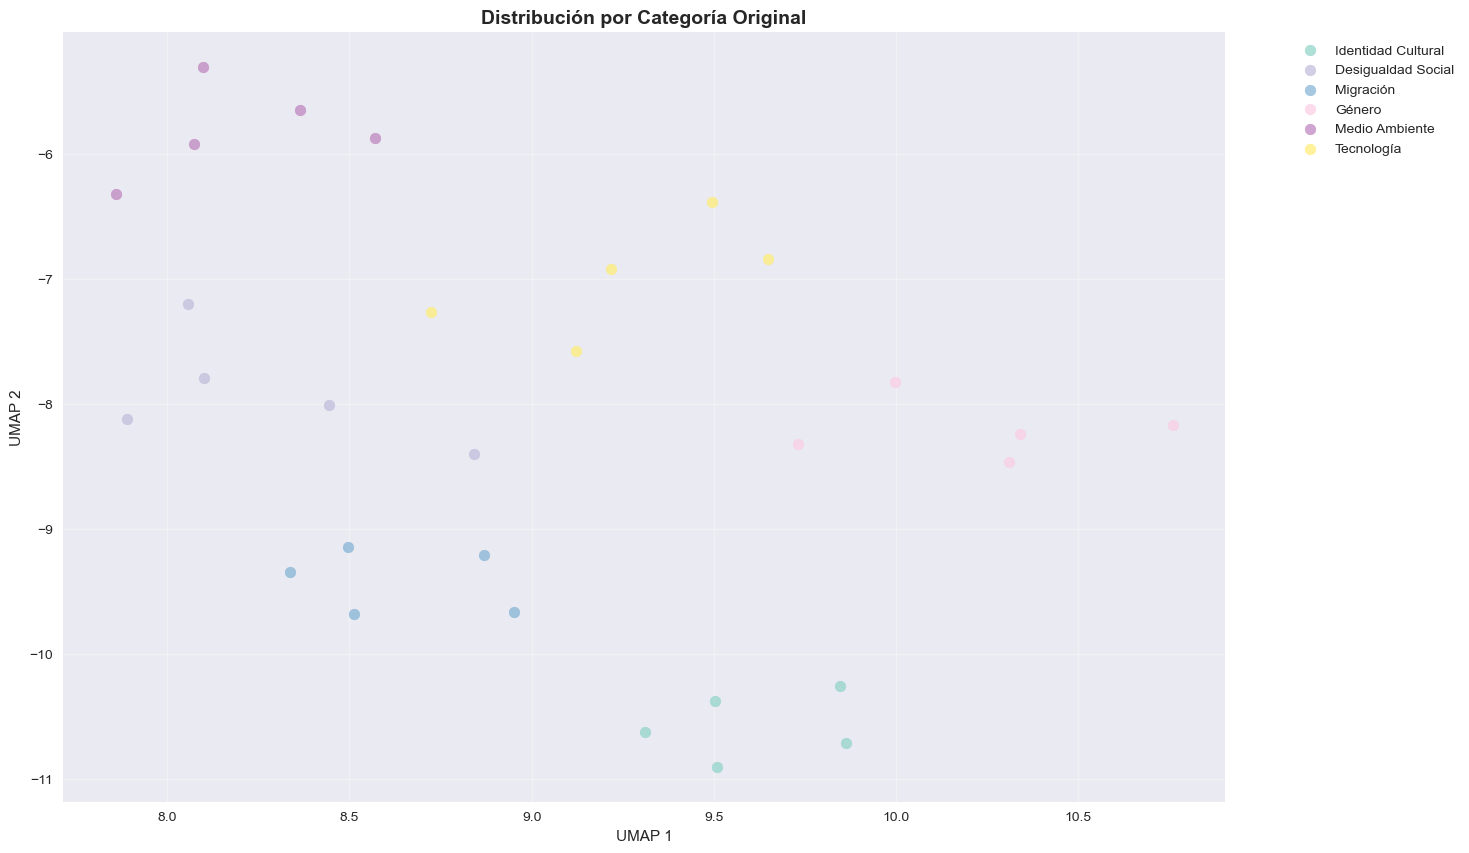

In [10]:
# Visualización con matplotlib
plt.figure(figsize=(15, 10))

# Subplot 1: Clusters por categoría original

categorias = df['categoria'].unique()
colores = plt.cm.Set3(np.linspace(0, 1, len(categorias)))

for i, categoria in enumerate(categorias):
    mask = df['categoria'] == categoria
    plt.scatter(df.loc[mask, 'x'], df.loc[mask, 'y'], 
               c=[colores[i]], label=categoria, alpha=0.7, s=60)

plt.title('Distribución por Categoría Original', fontsize=14, fontweight='bold')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)




In [11]:
# Visualización interactiva con Plotly - Solo categorías originales
fig = go.Figure()

# Gráfico por categoría original
for categoria in df['categoria'].unique():
    mask = df['categoria'] == categoria
    fig.add_trace(
        go.Scatter(
            x=df.loc[mask, 'x'],
            y=df.loc[mask, 'y'],
            mode='markers',
            name=categoria,
            text=df.loc[mask, 'oracion'],
            hovertemplate='<b>%{text}</b><br>Categoría: ' + categoria + '<extra></extra>',
            marker=dict(size=10, opacity=0.8)
        )
    )

# Actualizar layout
fig.update_layout(
    title="Visualización de Embeddings por Categoría Original",
    title_x=0.5,
    height=600,
    width=800,
    showlegend=True,
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2"
)

# Mostrar la figura
fig.show()


## 5. Análisis de Similitud Semántica

Vamos a explorar las similitudes semánticas entre las oraciones usando los embeddings generados.


In [15]:
# Calcular matriz de similitud coseno
from sklearn.metrics.pairwise import cosine_similarity

print("Calculando matriz de similitud coseno...")
matriz_similitud = cosine_similarity(embeddings)

# Crear DataFrame con la matriz de similitud
df_similitud = pd.DataFrame(
    matriz_similitud,
    index=df['oracion'],
    columns=df['oracion']
)

print(f"Forma de la matriz de similitud: {matriz_similitud.shape}")

# Encontrar las oraciones más similares para cada oración
print("\n=== ORACIONES MÁS SIMILARES ===")
for i, oracion in enumerate(df['oracion']):
    # Obtener similitudes (excluyendo la oración consigo misma)
    similitudes = matriz_similitud[i]
    indices_similares = np.argsort(similitudes)[::-1][1:4]  # Top 3 más similares
    
    print(f"\nOración: {oracion}")
    print("Más similares:")
    for j, idx in enumerate(indices_similares):
        similitud = similitudes[idx]
        print(f"  {j+1}. {df.iloc[idx]['oracion']} (similitud: {similitud:.3f})")
    
    if i >= 2:  # Mostrar solo las primeras 3 para no saturar
        print("\n... (mostrando solo las primeras 3 oraciones)")
        break


Calculando matriz de similitud coseno...
Forma de la matriz de similitud: (30, 30)

=== ORACIONES MÁS SIMILARES ===

Oración: La identidad cultural se forma a través de las tradiciones familiares
Más similares:
  1. Las costumbres ancestrales moldean nuestra identidad cultural (similitud: 0.833)
  2. El idioma materno es un pilar de la identidad cultural (similitud: 0.772)
  3. Las celebraciones tradicionales fortalecen la identidad cultural (similitud: 0.714)

Oración: Las costumbres ancestrales moldean nuestra identidad cultural
Más similares:
  1. La identidad cultural se forma a través de las tradiciones familiares (similitud: 0.833)
  2. Las celebraciones tradicionales fortalecen la identidad cultural (similitud: 0.753)
  3. El idioma materno es un pilar de la identidad cultural (similitud: 0.736)

Oración: La música folclórica es parte fundamental de la identidad cultural
Más similares:
  1. Las costumbres ancestrales moldean nuestra identidad cultural (similitud: 0.705)
  2. Las

## 7. Conclusiones y Aplicaciones

### ¿Qué hemos aprendido?

1. **Embeddings Semánticos**: Los modelos de transformers pueden capturar el significado semántico de texto en español, representándolo como vectores densos de alta dimensionalidad.

2. **Reducción de Dimensionalidad**: UMAP es efectivo para visualizar embeddings preservando tanto la estructura local como global de los datos.


3. **Similitud Semántica**: La similitud coseno entre embeddings refleja relaciones semánticas entre oraciones.

### Aplicaciones Prácticas

- **Análisis de Sentimientos**: Clasificar automáticamente opiniones o comentarios
- **Búsqueda Semántica**: Encontrar documentos similares basándose en significado, no solo palabras clave
- **Detección de Temas**: Identificar automáticamente temas en grandes corpus de texto
- **Recomendación de Contenido**: Sugerir artículos o posts similares
- **Análisis de Redes Sociales**: Agrupar conversaciones por temas


## 8. Ejercicios Adicionales

### Para Practicar Más:

1. **Experimenta con diferentes modelos**:
   ```python
   # Prueba otros modelos de embeddings en español
   modelo_alternativo = SentenceTransformer('dccuchile/bert-base-spanish-wwm-uncased')
   ```

2. **Ajusta parámetros de UMAP**:
   - Cambia `n_neighbors` (5, 10, 20, 50)
   - Modifica `min_dist` (0.01, 0.1, 0.5, 1.0)
   - Observa cómo cambian las visualizaciones


3. **Agrega más oraciones**:
   - Incluye nuevas categorías temáticas
   - Experimenta con oraciones más largas o más cortas
   - Prueba con texto más técnico o coloquial

4. **Análisis de calidad**:
   - Calcula métricas como el coeficiente de silueta
   - Compara con clustering jerárquico
   - Evalúa la coherencia semántica de los clusters


## 9. Recursos Adicionales

### Documentación y Tutoriales:
- [Sentence Transformers Documentation](https://www.sbert.net/)
- [UMAP Documentation](https://umap-learn.readthedocs.io/)
- [Scikit-learn Clustering](https://scikit-learn.org/stable/modules/clustering.html)

### Modelos de Embeddings en Español:
- `paraphrase-multilingual-MiniLM-L12-v2` (usado en este tutorial)
- `dccuchile/bert-base-spanish-wwm-uncased`
- `PlanTL-GOB-ES/roberta-base-bne`
- `microsoft/DialoGPT-medium` (para diálogos)

### Herramientas Relacionadas:
- **spaCy**: Procesamiento de lenguaje natural
- **Transformers**: Biblioteca de Hugging Face
- **Gensim**: Modelado de temas y word2vec
- **BERTopic**: Clustering de temas con BERT

---


